# CICDDoS2019

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py.functions import (
    plot_confusion_matrix, 
    criar_stream, 
    remover_colunas_correlacionadas,
    carregar_e_unificar,
    identificar_features_importantes,
    visualizar_radares_separados_referencia,
    analisar_grupos_similares,
    identificar_assinaturas_por_ataque,
    visualizar_assinaturas_barras
)

In [3]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv'   
    # 'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

CHUNK_SIZE = 100000  

df = carregar_e_unificar(ARQUIVOS_ALVO, CHUNK_SIZE)
df.value_counts("Label")

Iniciando processamento integral de 1 arquivos...
Dataset Unificado Pronto: 1180678 linhas.


Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64

In [ ]:
# df_analise = remover_colunas_correlacionadas(df_analise, 0.95)

# top_features = identificar_features_importantes(df_analise, top_n=15)

# visualizar_radares_separados_referencia(df_analise, top_features[:15])

# relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.98)
# display(relatorio_grupos)

# identificar_assinaturas_por_ataque(df_analise, 5, 10000, n_iteracoes=10)

## Processamento 

### Downsample 

In [57]:
def processar_e_salvar_dia(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


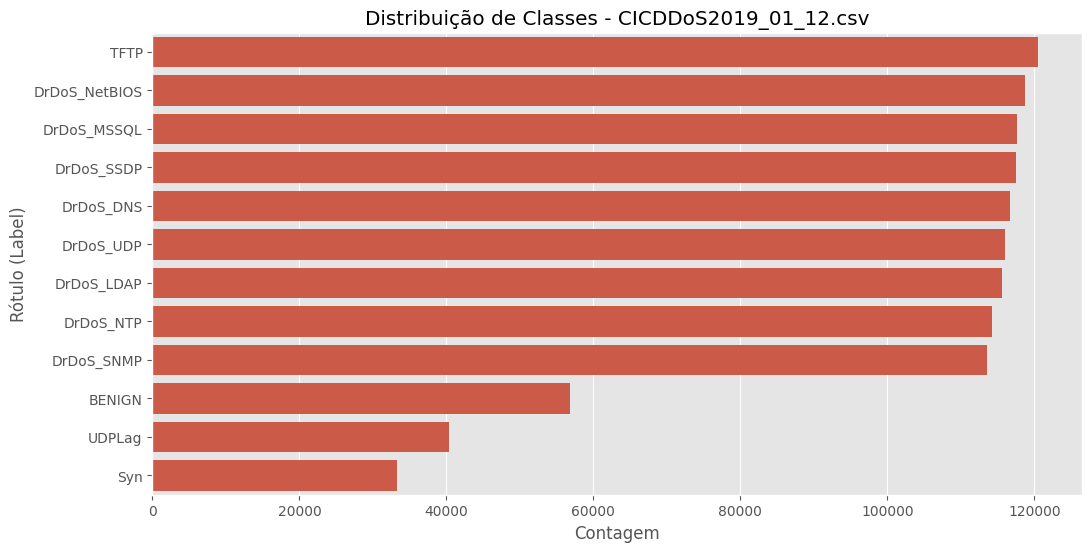

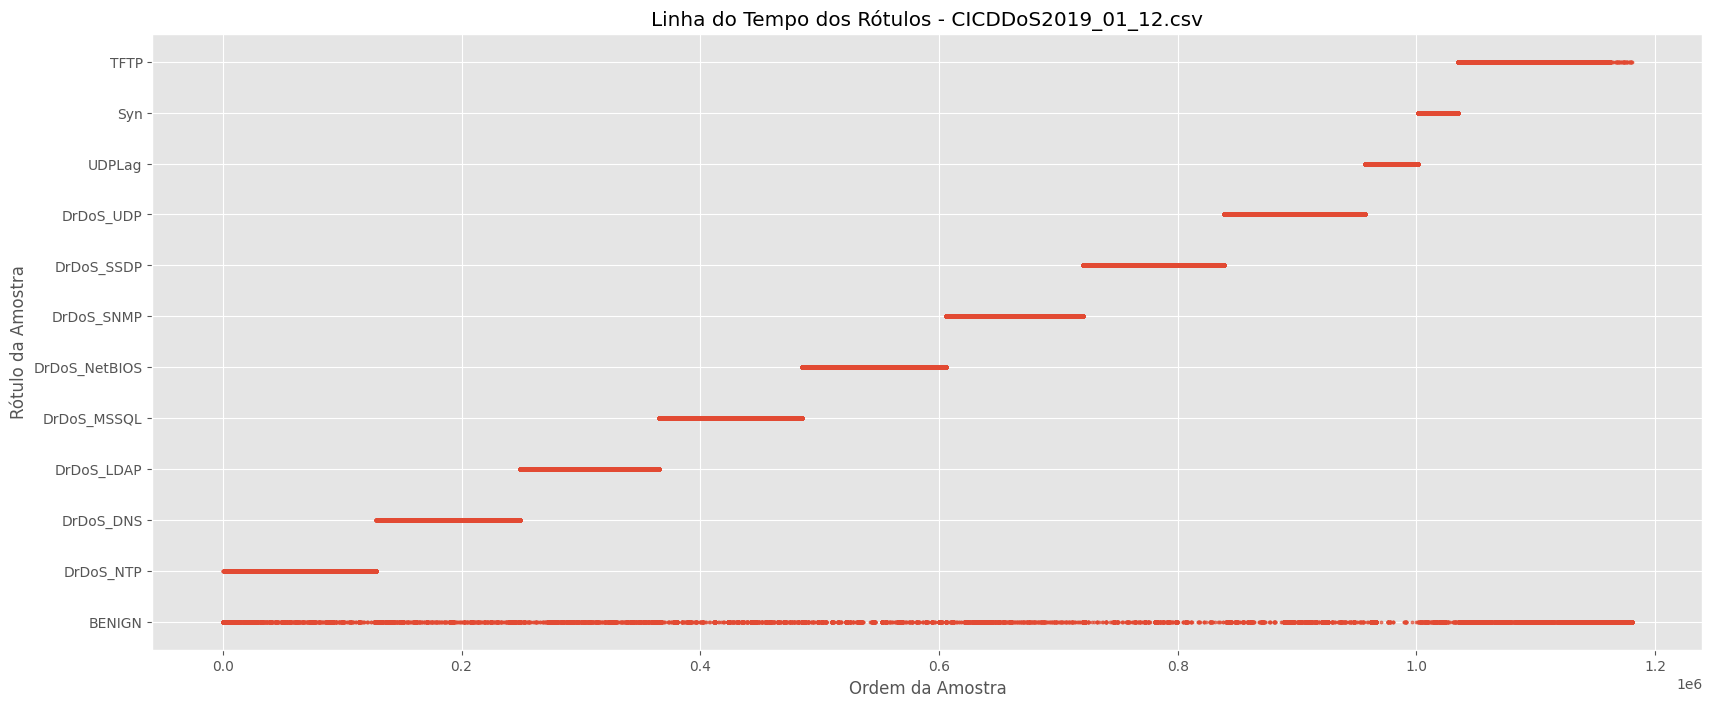

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.width', 1000)

COLUNA_LABEL = 'Label'
TAMANHO_AMOSTRA = 100000 

In [14]:
print(f"1. Preparação dos Dados (Amostra Estratificada: {TAMANHO_AMOSTRA})")

# Amostragem Estratificada 
n_amostra = min(TAMANHO_AMOSTRA, len(df))
df_amostra = df.groupby(COLUNA_LABEL, group_keys=False).sample(n=n_amostra // len(df[COLUNA_LABEL].unique()), random_state=42)

# Separação X (Features) e y (Alvo)
X_raw = df_amostra.drop(columns=[COLUNA_LABEL])
y = df_amostra[COLUNA_LABEL].reset_index(drop=True)

# Limpeza Numérica 
print("   > Limpando valores nulos e infinitos...")
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

# Normalização 
print("   > Normalizando distribuição (Gaussiana)...")
scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_trans = scaler.fit_transform(X_numeric)

# Prepara o LabelEncoder
le = LabelEncoder()
y_num = le.fit_transform(y)
labels_unique = y.unique()

print("2. Definindo Parâmetros para o Grid Search ")

# Grid do Random Forest 
rf_grid = {
    'max_depth': [12, 15],       
    'n_estimators': [100, 150],       
    'max_features': ['sqrt']   
}

# Grid de Clusters (Baseado na taxonomia do artigo)
max_search_k = len(labels_unique)
k_range = range(4, max_search_k) 

# Gera as combinações agora para deixar pronto
keys, values = zip(*rf_grid.items())
rf_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"   > Configurações de RF prontas: {len(rf_combinations)}")
print(f"   > Variações de Clusters prontas: {len(k_range)}")
print(f"   > Total de combinações a testar: {len(rf_combinations) * len(k_range)}")
df_amostra.value_counts("Label")

1. Preparação dos Dados (Amostra Estratificada: 100000)
   > Limpando valores nulos e infinitos...
   > Normalizando distribuição (Gaussiana)...
2. Definindo Parâmetros para o Grid Search 
   > Configurações de RF prontas: 4
   > Variações de Clusters prontas: 8
   > Total de combinações a testar: 32


Label
BENIGN           8333
DrDoS_DNS        8333
DrDoS_LDAP       8333
DrDoS_MSSQL      8333
DrDoS_NTP        8333
DrDoS_NetBIOS    8333
DrDoS_SNMP       8333
DrDoS_SSDP       8333
DrDoS_UDP        8333
Syn              8333
TFTP             8333
UDPLag           8333
Name: count, dtype: int64

In [15]:
print("3. Seleção de Features com Random Forest Regressor")

# O Regressor identifica quais colunas diminuem mais a impureza 
rf_reg = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42)
rf_reg.fit(X_trans, y_num)

# Extração das Top Features
importancias = rf_reg.feature_importances_
nomes_features = X_numeric.columns

df_imps = pd.DataFrame({'Feature': nomes_features, 'Importancia': importancias})
df_imps = df_imps.sort_values(by='Importancia', ascending=False)

TOP_N = 20
features_selecionadas = df_imps.head(TOP_N)['Feature'].tolist()

print(f"   > Top {TOP_N} Features selecionadas: {features_selecionadas}")


3. Seleção de Features com Random Forest Regressor
   > Top 20 Features selecionadas: ['ACK Flag Count', 'Fwd IAT Std', 'Max Packet Length', 'Init_Win_bytes_forward', 'Subflow Fwd Bytes', 'Total Length of Fwd Packets', 'Min Packet Length', 'Inbound', 'Flow Bytes/s', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Packet Length Mean', 'Average Packet Size', 'Fwd Packets/s', 'Flow IAT Min', 'Fwd IAT Min', 'min_seg_size_forward', 'Fwd IAT Max']


In [ ]:
print("4. Iniciando Grid Search")

# Filtra X_trans para usar apenas as Top Features 
indices_features = [X_numeric.columns.get_loc(c) for c in features_selecionadas]
X_grid = X_trans[:, indices_features] 

# Variáveis de Controle
best_score = -1
best_rf_params = {}
best_k = -1
best_rf_k_history = []

# Loop de Otimização
for i, rf_params in enumerate(rf_combinations):
    
    # Extrair Assinaturas com a config atual
    feature_signatures = []
    top_features_indices = set() 
    
    # Treina RF para cada classe usando a matriz reduzida (X_grid)
    for label in labels_unique:
        y_binary = (y == label).astype(int)
        
        # Treina 
        rf = RandomForestClassifier(**rf_params, n_jobs=-1, random_state=42)
        rf.fit(X_grid, y_binary)
        
        imps = rf.feature_importances_
        feature_signatures.append(imps)
        
        # Seleciona as Top 5 features DENTRO do subconjunto reduzido para validação
        top_features_indices.update(np.argsort(imps)[-10:])
    
    df_signatures = pd.DataFrame(feature_signatures, index=labels_unique)
    
    # Matriz de Distância Lógica
    sim_logic = cosine_similarity(df_signatures)
    dist_matrix = 1 - sim_logic
    np.fill_diagonal(dist_matrix, 0)
    dist_matrix = np.clip(dist_matrix, 0, 1)
    
    # Espaço de Validação (Focado apenas no que o RF achou relevante agora)
    X_val = X_grid[:, list(top_features_indices)]
    
    # Lista para guardar histórico
    current_rf_k_scores = []
    
    # Loop de Clusters (K)
    for k in k_range:
        clustering = AgglomerativeClustering(
            n_clusters=k, 
            metric='precomputed', 
            linkage='complete'
        )
        cluster_labels = clustering.fit_predict(dist_matrix)
        
        # Mapeia cluster -> amostra para calcular o Silhouette
        mapa = {l: c for l, c in zip(labels_unique, cluster_labels)}
        y_pred = y.map(mapa).values
        
        # Silhouette Score 
        score = silhouette_score(X_val, y_pred, sample_size=5000, random_state=42)
        current_rf_k_scores.append(score)
        
        # Verifica Recorde
        if score > best_score:
            best_score = score
            best_rf_params = rf_params
            best_k = k
            best_rf_k_history = list(current_rf_k_scores) 
            print(f"  >>> [Config RF {i+1}] Novo Recorde: Score={score:.4f} | K={k}")
            
    # Garante histórico completo se esta for a melhor config
    if rf_params == best_rf_params:
         best_rf_k_history = list(current_rf_k_scores)

print("\n=== Grid Search Concluído ===")
print(f"Melhor Score: {best_score:.4f}")
print(f"Melhor K: {best_k}")
print(f"Melhores Params RF: {best_rf_params}")

4. Iniciando Grid Search
  >>> [Config RF 1] Novo Recorde: Score=0.1361 | K=4
  >>> [Config RF 1] Novo Recorde: Score=0.2277 | K=5

=== Grid Search Concluído ===
Melhor Score: 0.2277
Melhor K: 5
Melhores Params RF: {'max_depth': 12, 'n_estimators': 100, 'max_features': 'sqrt'}


,Ataques,Similaridade Lógica,Top Features
0,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP",0.9442,"Avg Fwd Segment Size, Flow Bytes/s, Average Packet Size"
1,"DrDoS_MSSQL, DrDoS_NetBIOS",0.9642,"Subflow Fwd Bytes, Total Length of Fwd Packets, Avg Fwd Segment Size"
2,"DrDoS_SSDP, DrDoS_UDP",0.9877,"Avg Fwd Segment Size, Fwd Packet Length Max, Fwd Packet Length Min"
3,BENIGN,1.0000,"Inbound, URG Flag Count, Bwd Packets/s"
4,"Syn, UDPLag",0.9784,"Init_Win_bytes_forward, ACK Flag Count, Average Packet Size"
5,DrDoS_NTP,1.0000,"Total Length of Fwd Packets, act_data_pkt_fwd, Subflow Fwd Bytes"
6,TFTP,1.0000,"Fwd Packet Length Mean, Avg Fwd Segment Size, Min Packet Length"


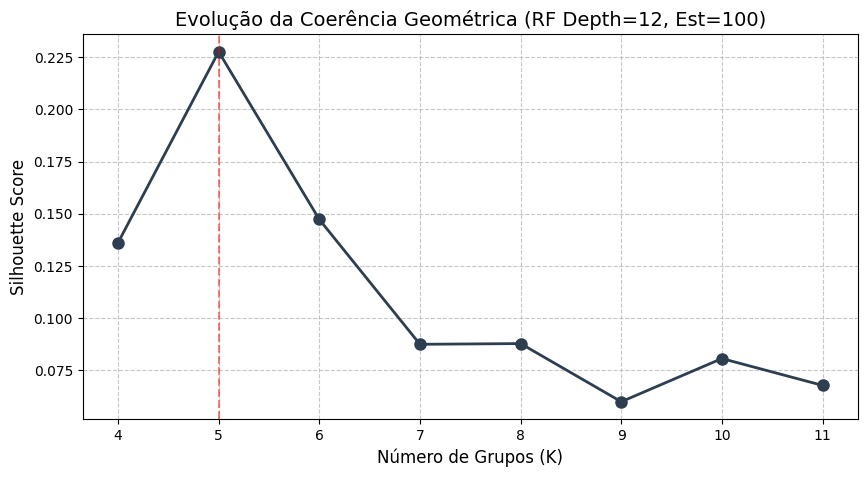

In [26]:
# Reconstrução do Modelo Vencedor
final_signatures = []
for label in labels_unique:
    y_binary = (y == label).astype(int)
    rf = RandomForestClassifier(**best_rf_params, n_jobs=-1, random_state=42)
    rf.fit(X_trans, y_binary)
    final_signatures.append(rf.feature_importances_)

df_final_sig = pd.DataFrame(final_signatures, index=labels_unique, columns=X_numeric.columns)

# Matriz e Cluster Final
final_sim = cosine_similarity(df_final_sig)
final_dist = 1 - final_sim
np.fill_diagonal(final_dist, 0)
final_clustering = AgglomerativeClustering(
    n_clusters=None, 
    metric='precomputed', 
    linkage='complete',
    distance_threshold=0.10
)
final_labels = final_clustering.fit_predict(final_dist)

# Construção da Tabela
report = []
for cid in sorted(set(final_labels)):
    membros = df_final_sig.index[final_labels == cid].tolist()
    
    # Similaridade Lógica (Média interna do grupo)
    if len(membros) > 1:
        sub_sim = pd.DataFrame(final_sim, index=labels_unique, columns=labels_unique).loc[membros, membros]
        mask = np.ones(sub_sim.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        # Pega a média apenas dos valores fora da diagonal
        avg_sim = sub_sim.values[mask].mean()
    else:
        avg_sim = 1.000 # Grupo unitário é perfeitamente similar a si mesmo
        
    # Top Features (Média de importância do grupo)
    avg_imp = df_final_sig.loc[membros].mean()
    top_feats = avg_imp.nlargest(3).index.tolist()
    
    report.append({
        'Ataques': ", ".join(membros),
        'Similaridade Lógica': f"{avg_sim:.4f}",
        'Top Features': ", ".join(top_feats)
    })

df_report = pd.DataFrame(report)
display(df_report)

# Evolução da Coerência Geométrica (Silhouette Score) por K
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), best_rf_k_history, marker='o', linestyle='-', color='#2c3e50', linewidth=2, markersize=8)
plt.title(f"Evolução da Coerência Geométrica (RF Depth={best_rf_params['max_depth']}, Est={best_rf_params['n_estimators']})", fontsize=14)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.5, label='Melhor K')
plt.xlabel("Número de Grupos (K)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

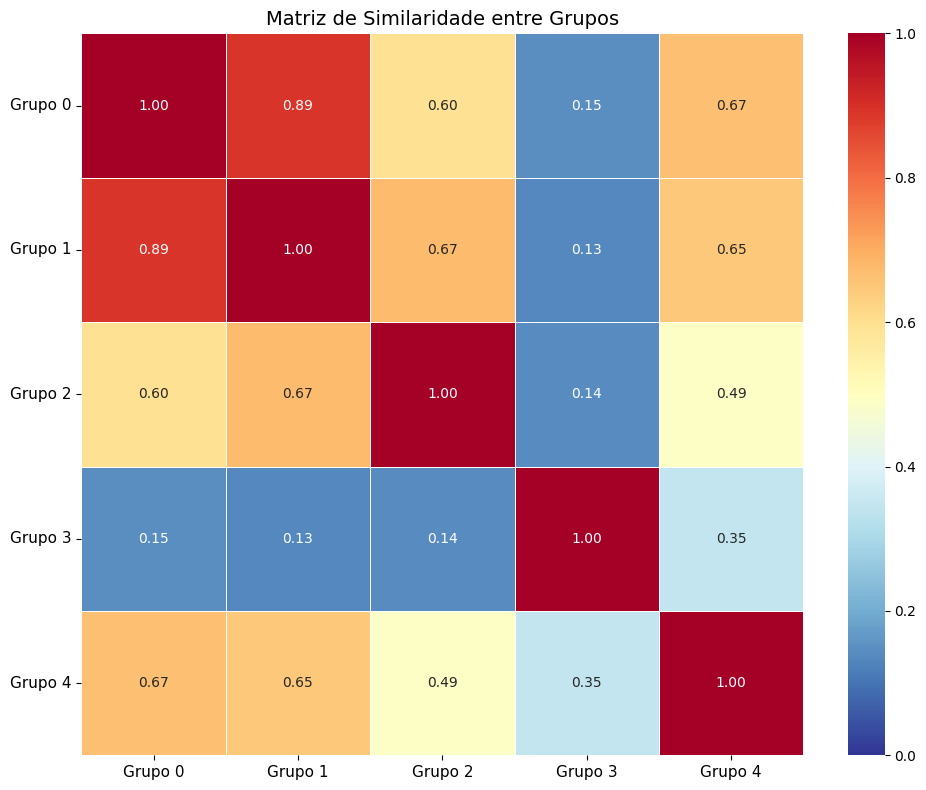

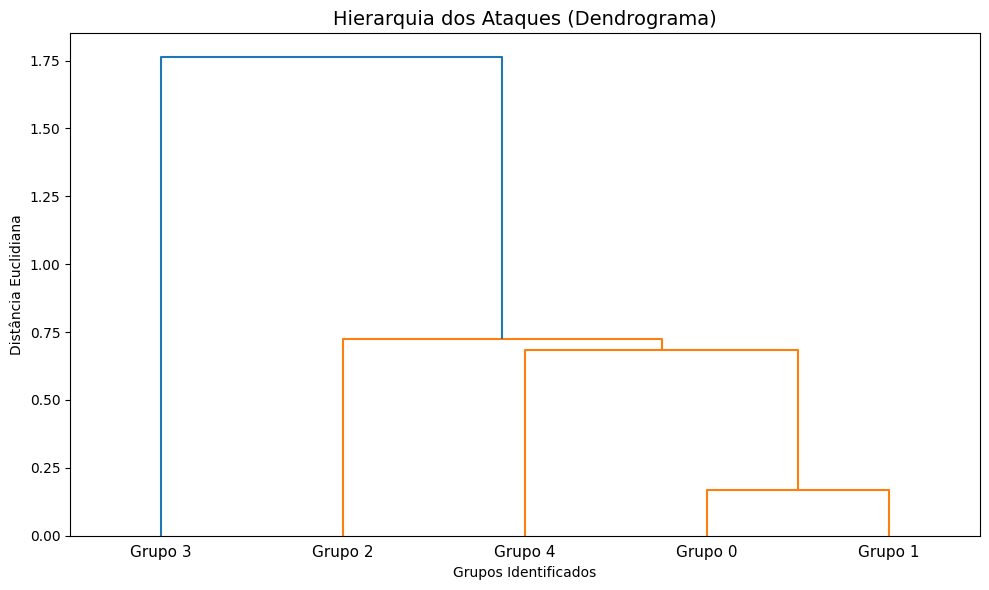

In [19]:
# Recuperando dados brutos da memória
unique_clusters = sorted(list(set(final_labels)))
cluster_vectors = []
cluster_names = []

for cid in unique_clusters:
    # Encontra índices dos ataques neste cluster
    indices = [i for i, label in enumerate(final_labels) if label == cid]
    
    # Calcula o vetor médio (Centróide)
    mean_vector = df_final_sig.iloc[indices].mean().values
    cluster_vectors.append(mean_vector)
    cluster_names.append(f"Grupo {cid}")

# Calcula similaridade
cluster_sim_matrix = cosine_similarity(cluster_vectors)
df_cluster_sim = pd.DataFrame(cluster_sim_matrix, index=cluster_names, columns=cluster_names)

# 1. Plotar Heatmap (Matriz Limpa)
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_cluster_sim, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlBu_r', 
    vmin=0, 
    vmax=1,
    square=True,
    linewidths=.5
)
plt.title("Matriz de Similaridade entre Grupos", fontsize=14)
plt.xticks(rotation=0, fontsize=11) 
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# 2. Plotar Dendrograma (Árvore Limpa)
plt.figure(figsize=(10, 6))
Z = linkage(df_cluster_sim, method='ward') 

dendrogram(
    Z,
    labels=cluster_names,
    leaf_rotation=0.,  # Rotação 0 deixa o texto reto (melhor para leitura)
    leaf_font_size=11.,
    color_threshold=0.7 * max(Z[:, 2])
)
plt.title("Hierarquia dos Ataques (Dendrograma)", fontsize=14)
plt.xlabel("Grupos Identificados")
plt.ylabel("Distância Euclidiana")
plt.tight_layout()
plt.show()

## Base de dados para verificar se os modelos identificam a semelhança entre os ataques durante o treinamento

In [17]:
import pandas as pd
import numpy as np
import os

def gerar_cenario_dinamico(df, sequencia_labels, pct_sujeira, tamanho_bloco_ataque, nome_cenario, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    df = df.drop(columns=['Origem_Arquivo', 'Unnamed: 0'], errors='ignore')
    
    df_benign_pool = df[df['Label'] == 'BENIGN'].sample(frac=1, random_state=42)
    total_benign_disponivel = len(df_benign_pool)
    
    qtd_ataques = len([x for x in sequencia_labels if x != 'BENIGN'])
    qtd_intervalos_benign = len([x for x in sequencia_labels if x == 'BENIGN'])
    
    qtd_ruido_por_ataque = int(tamanho_bloco_ataque * pct_sujeira)
    qtd_ataque_puro = int(tamanho_bloco_ataque * (1 - pct_sujeira))
    
    total_ruido_necessario = qtd_ruido_por_ataque * qtd_ataques
    
    if total_ruido_necessario > total_benign_disponivel:
        raise ValueError(f"Erro: Não há dados benignos suficientes para o ruído solicitado. Necessário: {total_ruido_necessario}, Disponível: {total_benign_disponivel}")
    
    df_noise_pool = df_benign_pool.iloc[:total_ruido_necessario]
    df_benign_intervals_pool = df_benign_pool.iloc[total_ruido_necessario:]
    
    tamanho_intervalo_benign = 0
    if qtd_intervalos_benign > 0:
        tamanho_intervalo_benign = int(len(df_benign_intervals_pool) / qtd_intervalos_benign)
    
    df_list = []
    metadata = []
    indice_global = 0
    
    idx_noise = 0
    idx_interval = 0
    
    for label in sequencia_labels:
        if label == 'BENIGN':
            start = idx_interval * tamanho_intervalo_benign
            end = start + tamanho_intervalo_benign
            
            chunk = df_benign_intervals_pool.iloc[start:end]
            df_list.append(chunk)
            
            metadata.append({
                'Evento': f"BENIGN_Intervalo_{idx_interval+1}",
                'Inicio': indice_global,
                'Fim': indice_global + len(chunk),
                'Tipo': 'Normal'
            })
            
            indice_global += len(chunk)
            idx_interval += 1
            
        else:
            start_noise = idx_noise * qtd_ruido_por_ataque
            end_noise = start_noise + qtd_ruido_por_ataque
            noise_chunk = df_noise_pool.iloc[start_noise:end_noise]
            
            try:
                attack_raw = df[df['Label'] == label].sample(n=qtd_ataque_puro, random_state=42 + idx_noise)
            except ValueError:
                print(f"Aviso: Dados insuficientes para o ataque {label}. Usando o que tem disponível.")
                attack_raw = df[df['Label'] == label]
            
            attack_block = pd.concat([attack_raw, noise_chunk]).sample(frac=1, random_state=42)
            df_list.append(attack_block)
            
            metadata.append({
                'Evento': f"ATAQUE_{label}",
                'Inicio': indice_global,
                'Fim': indice_global + len(attack_block),
                'Tipo': 'Ataque'
            })
            
            indice_global += len(attack_block)
            idx_noise += 1
            
    df_final = pd.concat(df_list, ignore_index=True)
    
    csv_name = f"stream_{nome_cenario}.csv"
    meta_name = f"metadata_{nome_cenario}.csv"
    
    df_final.to_csv(os.path.join(output_dir, csv_name), index=False)
    pd.DataFrame(metadata).to_csv(os.path.join(output_dir, meta_name), index=False)
    
    print(f"Cenário '{nome_cenario}' gerado com sucesso em: {output_dir}")
    print(f"Estrutura: {len(df_final)} linhas | {pct_sujeira*100}% de sujeira nos ataques.")
    
    return df_final, metadata

In [20]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000  
SUJEIRA = 0.40         

sequencia_c1 = [
    'BENIGN', 
    'DrDoS_LDAP', 
    'BENIGN', 
    'DrDoS_NetBIOS', 
    'BENIGN', 
    'Syn', 
    'BENIGN'
]

df_c1, meta_c1 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c1,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Imunidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_1")
)

sequencia_c2 = [
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN', 
    'DrDoS_MSSQL', 
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN'
]

df_c2, meta_c2 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c2,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Memoria",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_2")
)

sequencia_c3 = [
    'BENIGN', 
    'UDP', 
    'BENIGN', 
    'DrDoS_NTP', 
    'BENIGN', 
    'DrDoS_DNS', 
    'BENIGN'
]

df_c3, meta_c3 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c3,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Complexidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_3")
)

Cenário 'Imunidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_1
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Memoria' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_2
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Complexidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_3
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
